## Plots delays, throughputs, packet loss and path for a selected link

In [32]:
%matplotlib inline
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from datetime import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
from datetime import datetime
import numpy as np
import pandas as pd

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)
my_index = "network_weather_2-*"

my_query = {}

##  Select your link

In [33]:
sS='UC'
srcSiteOWDServer = "192.170.227.160"
srcSiteThroughputServer = "192.170.227.162"

# sS='IU'
# srcSiteOWDServer = "149.165.225.223"
# srcSiteThroughputServer = "149.165.225.224"

dS='UIUC'
destSiteOWDServer = "72.36.96.4"
destSiteThroughputServer = "72.36.96.9"

# dS='ICCN'
# destSiteOWDServer = "72.36.96.4"
# destSiteThroughputServer = "72.36.126.132"

## Get the data from Elasticsearch, and store the record based on its type

In [44]:
my_query = {
    'query':{
        'filtered':{
            'query': { "match_all": {} },
            'filter':{
                'bool':{
                    'must':[
                        {'range': {'timestamp': {'gte': '2016-08-04', 'lt': '2016-08-06'}}},
                        {'bool':
                            {'should':[
                                {'term': {'src': srcSiteOWDServer}},
                                {'term': {'src': srcSiteThroughputServer}},
                                {'term': {'src': destSiteOWDServer}},
                                {'term': {'src': destSiteThroughputServer}}
                            ]}
                        },
                        {'bool':
                            {'should':[
                                {'term': {'dest': destSiteOWDServer}},
                                {'term': {'dest': destSiteThroughputServer}},
                                {'term': {'dest': srcSiteOWDServer}},
                                {'term': {'dest': srcSiteThroughputServer}}
                            ]}
                        }
                    ]
                }
            }
        }
    }
}

scroll = list(scan(client=es, query=my_query))


In [45]:
site = {srcSiteOWDServer: sS, srcSiteThroughputServer: sS, destSiteOWDServer:dS, destSiteThroughputServer:dS}
data = {sS:pd.DataFrame(),dS:pd.DataFrame()}
epoch = datetime.utcfromtimestamp(0)
count = 0
for res in scroll:
    count += 1
    dt=datetime.strptime(res['_source']['timestamp'], '%Y-%m-%dT%H:%M:%S')
    ts = (dt - epoch).total_seconds() * 1000.0
    s=site[res['_source']['src']]
    data[s].set_value(ts, 'timestamp', dt)
    column_type = res['_type']
    if column_type == 'latency':
        data[s].set_value( ts, 'delay_median', res['_source']['delay_median'])
        data[s].set_value( ts, 'delay_mean', res['_source']['delay_mean'])
        data[s].set_value( ts, 'delay_sd', res['_source']['delay_sd'])
    elif column_type == 'packet_loss_rate':
        data[s].set_value( ts, 'packet_loss', res['_source']['packet_loss'])
    elif column_type == 'throughput':
        data[s].set_value( ts, 'throughput', res['_source']['throughput']/1024./1024./1024.)
    elif column_type == 'traceroute':
        data[s].set_value( ts, 'hash', res['_source']['hash'])
    if count<2: print(res, ts)
print(count)

{'_id': 'AVZW-L18d25u_mmDUS-O', '_source': {'MA': '192.170.227.162', 'dest': '72.36.96.9', 'destProduction': False, 'src': '192.170.227.162', 'timestamp': '2016-08-04T19:09:45', 'hops': ['192.170.224.77', '192.170.225.6', '72.36.127.157', '72.36.126.98', '72.36.126.82', '72.36.126.94', '72.36.126.78', '72.36.126.73', '72.36.126.90', '72.36.126.69', '72.36.126.85', '72.36.127.186', '72.36.126.65', '130.126.1.110'], 'srcProduction': False, 'hash': -4653419685355079235, 'srcVO': 'ATLAS', 'destVO': 'ATLAS', 'destSite': 'MWT2', 'srcSite': 'MWT2'}, '_type': 'traceroute', '_score': 0.0, '_index': 'network_weather_2-2016.8.4'} 1470337785000.0
9794


### saving in pickle files

In [46]:
a=data[sS]
print (a.count(axis='index'))
a.sort_index(inplace=True)    # Sort the records based on time
a.to_pickle("Data/FullOneLinkData" + '_' + sS + '-' + dS + ".pkl")

a=data[dS]
print (a.count(axis='index'))
a.sort_index(inplace=True)    # Sort the records based on time
a.to_pickle("Data/FullOneLinkData" + '_' + dS + '-' + sS + ".pkl")

timestamp       1519
hash             933
packet_loss      549
delay_median     549
delay_mean       549
delay_sd         549
throughput        40
dtype: int64
timestamp       1528
delay_median     549
delay_mean       549
delay_sd         549
packet_loss      549
hash             940
throughput        46
dtype: int64


### Extract values

In [47]:
F = data[sS]
B = data[dS]
Fthr = F[F.throughput.notnull()]    # Get the lines (i.e. times) whose throughput is not null
Bthr = B[B.throughput.notnull()]  
Fpl = F[F.packet_loss.notnull()]
Bpl = B[B.packet_loss.notnull()]
# Fd = F[F.delay_mean.notnull()]
# Bd = B[B.delay_mean.notnull()]
Fd = F[F.delay_mean<10]
Bd = B[B.delay_mean<10]
Jd = Fd.join(Bd,how='inner', rsuffix="_back")
Jd['dmean']= (Jd.delay_mean + Jd.delay_mean_back)/2

Fh = F[F.hash.notnull()]
Bh = B[B.hash.notnull()]
Fids=[];Bids=[]
Fu=[];Bu=[]

for fi in Fh.hash.tolist():
    if fi not in Fu: Fu.append(fi)
    Fids.append(Fu.index(fi))
for fi in Bh.hash.tolist():
    if fi not in Bu: Bu.append(fi)
    Bids.append(Bu.index(fi))

In [48]:
# Fthr
#Fids

In [49]:
print( 'throughput  forward: ', Fthr.shape[0], ' backward: ', Bthr.shape[0])
print( 'packet loss forward: ', Fpl.shape[0],  ' backward: ', Bpl.shape[0])
print( 'delay       forward: ', Fd.shape[0],   ' backward: ', Bd.shape[0])
print( 'hash        forward: ', Fh.shape[0],   ' backward: ', Bh.shape[0])

throughput  forward:  40  backward:  46
packet loss forward:  549  backward:  549
delay       forward:  542  backward:  544
hash        forward:  933  backward:  940


2.37896926674 1.32098147627
2.15424204069 1.19836893453
2.24941570494 1.17093735961


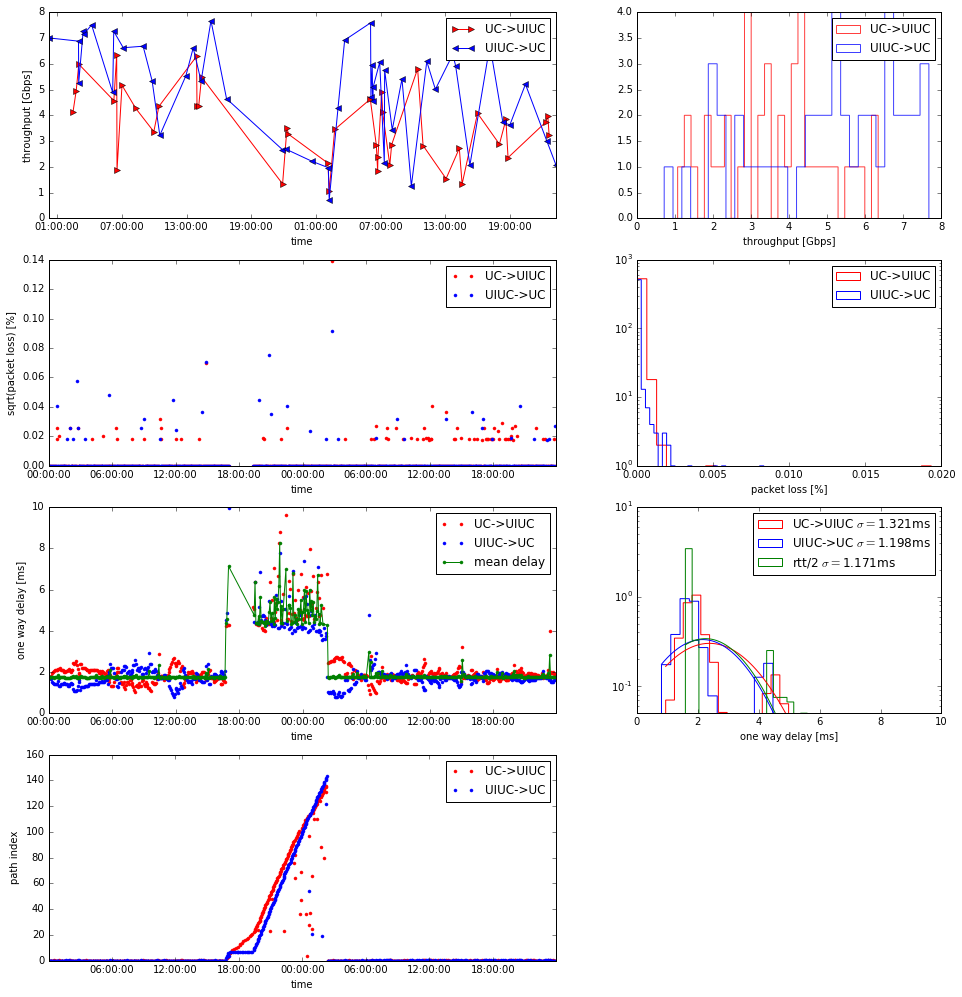

In [50]:
plt.figure(figsize=[16, 17])
gs = gridspec.GridSpec(4, 2, width_ratios=[5, 3])

ax0 = plt.subplot(gs[0,0])
ax0.plot(Fthr.timestamp.tolist(), Fthr.throughput.tolist(), ls='-', marker='>', c='r', label=sS+'->'+dS)
ax0.plot(Bthr.timestamp.tolist(), Bthr.throughput.tolist(), ls='-', marker='<', c='b', label=dS+'->'+sS)
ax0.set_xlabel('time')
ax0.set_ylabel('throughput [Gbps]')#,rotation='horizontal')
#ax0.xlim(xmin=0)
ax0.legend()

ax1 = plt.subplot(gs[0,1])
ax1.hist(Fthr.throughput.tolist(), 30, alpha=0.75, histtype='step', color='r', label=sS+'->'+dS)
ax1.hist(Bthr.throughput.tolist(), 30, alpha=0.75, histtype='step', color='b', label=dS+'->'+sS)
ax1.set_xlabel('throughput [Gbps]')
ax1.legend()

ax2 = plt.subplot(gs[1,0])
ax2.plot(Fpl.timestamp.tolist(), np.sqrt(Fpl.packet_loss).tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
ax2.plot(Bpl.timestamp.tolist(), np.sqrt(Bpl.packet_loss).tolist(), ls='', marker='.', c='b', label=dS+'->'+sS)
ax2.set_xlabel('time')
ax2.set_ylabel('sqrt(packet loss) [%]')
ax2.legend()

ax3 = plt.subplot(gs[1,1])
ax3.hist(Fpl.packet_loss.tolist(), 30, alpha=1, histtype='step', color='r', label=sS+'->'+dS)
ax3.hist(Bpl.packet_loss.tolist(), 30, alpha=1, histtype='step', color='b', label=dS+'->'+sS)
ax3.set_yscale('log')
ax3.set_xlabel('packet loss [%]')
ax3.legend()

ax4 = plt.subplot(gs[2,0])
ax4.plot(Fd.timestamp.tolist(), Fd.delay_mean.tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
ax4.plot(Bd.timestamp.tolist(), Bd.delay_mean.tolist(), ls='', marker='.', c='b', label=dS+'->'+sS)
ax4.plot(Jd.timestamp.tolist(), Jd.dmean.tolist(), ls='-', marker='.', c='g', label='mean delay')
ax4.set_xlabel('time')
ax4.set_ylabel('one way delay [ms]')
ax4.legend()

Fds=Fd.delay_mean.tolist()
Bds=Bd.delay_mean.tolist()
Jds=Jd.dmean.tolist()
ax5 = plt.subplot(gs[2,1])
Fmean = np.mean(Fds); Fvariance = np.var(Fds); Fsigma = np.sqrt(Fvariance)
print(Fmean, Fsigma)
Bmean = np.mean(Bds); Bvariance = np.var(Bds); Bsigma = np.sqrt(Bvariance)
print(Bmean, Bsigma)
Jmean = np.mean(Jds); Jvariance = np.var(Jds); Jsigma = np.sqrt(Jvariance)
print(Jmean, Jsigma)
Fx = np.linspace(min(Fds), max(Fds),100)
Bx = np.linspace(min(Bds), max(Bds),100)
Jx = np.linspace(min(Jds), max(Jds),100)

ax5.hist(Fds, 30, alpha=1, histtype='step', normed=1, color='r', label=sS+'->'+dS + " $\sigma=${:.3f}ms".format(Fsigma))
ax5.hist(Bds, 30, alpha=1, histtype='step', normed=1, color='b', label=dS+'->'+sS + " $\sigma=${:.3f}ms".format(Bsigma))
ax5.hist(Jds, 30, alpha=1, histtype='step', normed=1, color='g', label='rtt/2' + " $\sigma=${:.3f}ms".format(Jsigma))
ax5.set_yscale('log')
ax5.set_ylim(ymin=0.05)
ax5.set_xlabel('one way delay [ms]')
ax5.plot(Fx,mlab.normpdf(Fx,Fmean,Fsigma), color='r',)
ax5.plot(Bx,mlab.normpdf(Bx,Bmean,Bsigma), color='b')
ax5.plot(Jx,mlab.normpdf(Jx,Jmean,Jsigma), color='g')
ax5.legend()

ax6 = plt.subplot(gs[3,0])
ax6.plot(Fh.timestamp.tolist(), Fids, ls='', marker='.', c='r', label=sS+'->'+dS)
ax6.plot(Bh.timestamp.tolist(), Bids, ls='', marker='.', c='b', label=dS+'->'+sS)
ax6.set_xlabel('time')
ax6.set_ylabel('path index')
ax6.legend()

plt.savefig('Plots/AllPlotForLink_' + sS +'_'+ dS + '.png',dpi=200)
plt.show()

## the last plot should be changed:
* paths should be changed to include starting IP
* we should store two hashes (forward and backward)
* here one should for backward path take backward hash
* ids should come from the same pool